In [157]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as ax
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import unicodedata
from scipy.optimize import curve_fit
import pycountry as pc
import math

DATA_DIR = "./data/"
DEMO_DIR = "./population/"
DEM = "https://www.populationpyramid.net/"
WEB = "https://www.worldometers.info/coronavirus/"

MIG = pd.read_csv("MIG.csv",low_memory=False)
idx = MIG[MIG["Country of birth/nationality"] =='Former Czechoslovakia'].index
MIG.drop(idx,inplace=True)

DEM_DICT = {}
IMM_DICT = {}

# COVID-19 expansion tracking and Mathematical Model.

### 0. Introduction and motivation

SARS-CoV-2 is a virus belonging to the coronaviruses family that was first detected in Hubei province, Mainland China, in December 2019 and triggered an ongoing global pandemia.
Because of the high $R_0$ (estimated between 2 and 3) and the asymptomatic nature of the incubation period, it's necessary to develop mathematical models for prediction, that will prevent further consecuencies by anticipating expansion rate.

### 1. Preliminary analysis

This section is intended to act like a toolbox providing access to resources and data management functions, visualization tools will also be provided.

#### 1.1 Time Tracking and real time evolution

In [8]:
columns = ["Country/Region","Confirmed","Deaths","Recovered"]

In [158]:
def timeEvolution(country):
    data_files = sorted(os.listdir(DATA_DIR))
    """
    Returns a pandas DataFrame with information of a country (Confirmed,Deaths,Recovered) by day
    since the beginig of the outbreak.
    
    params:
    
        -country (String): target country
    
    returns:
        -Pandas DataFrame if information is available , else None.
    """
    dic = []
    for file in data_files:
        key = file.split(".csv")[0]
        df = pd.read_csv(DATA_DIR + file)
        indexes = df["Country/Region"] == country #rows associated with country
        if any(indexes):
            country_data = df[df["Country/Region"] == country][columns].sum() #all records of that country
            dic.append([key]+list(country_data[columns[1:]]))
        else: #no rows
            dic.append([key,0,0,0])
    
    df = pd.DataFrame(dic)
    df.columns = ["Date"]+columns[1:]
    return df
        
def worldTimeEvolution(): #about 20s
    data_files = sorted(os.listdir(DATA_DIR))
    """
    Returns a dictionary indexed by country of DataFrames with information about countries since outbreak
    
    returns:
        -dictionatry of pandas DataFrames
    """
    dic = {}
    countries = pd.read_csv(DATA_DIR+data_files[-1])["Country/Region"].unique()
    for country in countries:
        dic[country] = timeEvolution(country)  
    return dic

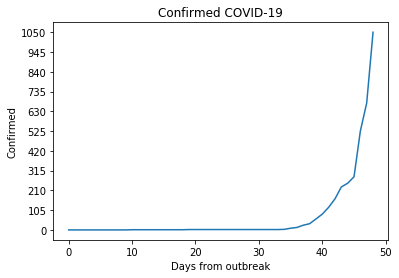

In [159]:
def graphProgression(countryDF,param): #TODO: x axis problem with dates, too messy
    """
    Graphs the progression in time of a given parameter regarding country info
    
    params:
        -countryDF (pandas.DataFrame): info about the country (see timeEvolution or worldTimeEvolution)
        -param (String): "Confirmed" -> confirmed cases of COVID-19 in country
                         "Deaths" -> deaths by COVID-19 in country
                         "Recovered" -> recovered patients in country 

    """
   
    x = range(len(countryDF["Date"]))
    y = list(countryDF[param].astype(int))
    plt.plot(x,y)
    
    y_max = max(y)
    if y_max < 10:
        plt.yticks(range(0,max(y)+1,1))
    else:
        plt.yticks(range(0,max(y)+1,max(y)//10))
    plt.title("{} COVID-19".format(param))
    plt.ylabel(param)
    plt.xlabel("Days from outbreak")
    plt.show()

graphProgression(timeEvolution("Spain"),"Confirmed")

In [160]:
def realTimeEvolution():
    """
    Returns a Pandas DataFrame with infomration about the real time expansion of the virus.
    
    returns:
        -pandas Dataframe
    """
    cols = ["Country","Total Cases","New Cases","Total Deaths","New Deaths","Active Cases","Total Recovered","Critical","Tot Cases/1 M Pop"]
    page = requests.get(WEB)
    soup = BeautifulSoup(page.content, 'html.parser')
    countryTable = soup.find_all('tbody')[0]
    rows = countryTable.find_all("tr")
    data =[]
    for row in rows:
        info = row.find_all("td")
        
        data.append([data.text.strip().replace(",","") if data.text.strip() != "" else "0" for data in info])
    table = pd.DataFrame(data,columns=cols)
    #drop row 'Total:' as of now
    table.drop(table.tail(1).index, inplace=True)
    return table

def updateData():
    """
    Stores today's evolution data in csv format
    
    """
    df = realTimeEvolution()[["Country","Total Cases","Total Deaths","Total Recovered"]]
    df.columns=columns
    now = datetime.now()
    df.to_csv(DATA_DIR+now.strftime("%Y-%m-%d-%H-%M.csv"))
#updateData()

#### 1.2 Dictionaries for resource mining

In [161]:
# Functions to initialize dictionaries for resource mining
def lcs(s1,s2): 
  
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
            if m[x][y] > longest:
                longest = m[x][y]
                x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

def countryPred(country,possibleCountries): 
    pred = sorted(possibleCountries,key=lambda x: len(lcs(country.replace(" ","").replace("China,","").replace("North","").replace(" China,",""),x.replace(" ","").replace("China,","").replace(" China,","").replace("North",""))),reverse=True)[0]
    return pred


def genDic(option):
    realtime_countries = list(realTimeEvolution()['Country'].values)
    if option == "IMM":
        possibleCountries = MIG["Country of birth/nationality"].unique()
    elif option == "DEM":
        possibleCountries = [file.split(".csv")[0] for file in os.listdir(DEMO_DIR)]
    
    countries = [(country,countryPred(country,possibleCountries)) for country in realtime_countries]
    trash = ['Monaco', 'San Marino', 'Faeroe Islands', 'Andorra', 'Diamond Princess', 'Taiwan', 'Gibraltar', 'Vatican City', 'Liechtenstein']
    dic = {}
    for country,pred in countries:
        if country not in pred:
            if country == "USA":
                if option == "IMM":
                    pred = "United States" #change
                if option == "DEM":
                    pred = "United States of America"
            elif country == "UK":
                pred = "United Kingdom"
            elif country == "UAE":
                pred = "United Arab Emirates"
            elif country in trash:
                continue
            else:
                dic[country] = pred

        dic[country] = pred

    return dic

#NOTE: Take her to Alice in Wonderland Ballet

IMM_DICT = genDic("IMM")
DEM_DICT = genDic("DEM")

#### 1.2 Demography by country

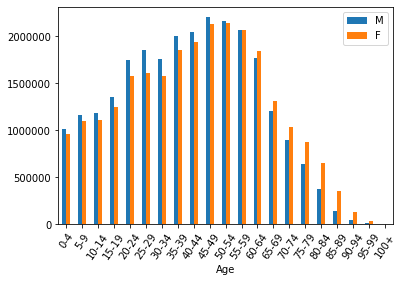

In [162]:
def saveDemography():
    """
    Mines https://www.populationpyramid.net and saves population pyramids 
    in csv files stored in the population directory
    """
    #TODO mine https://www.populationpyramid.net/<country>/2019/ , they have download by link, need to know country number, explore HTML + wget
    DEM = "https://www.populationpyramid.net/"
    html_page = requests.get(DEM)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    page_data = soup.find_all(class_='countryLink')
    l = []
    if not os.path.exists(DEMO_DIR):
        os.makedirs(DEMO_DIR)
    for country in page_data:
        d = {}
        aux = country.contents[0]
        if (aux == "Australia/New Zealand"):
            aux = "New Zealand"
        d['Country'] = aux
        d['ID'] = country['country']
        l.append(d)
        
    for country in l:
        c, ids = country.get("Country"), country.get("ID")
        CSV = "https://www.populationpyramid.net/api/pp/"+ids+"/2019?csv=true"
        r = requests.get(CSV)
        filename = c+".csv"
        file_path = os.path.join(DEMO_DIR, filename)
        if r.ok:
            print(filename + " : saving data to ... ", os.path.abspath(DEMO_DIR))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024 * 8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
        else:  # HTTP status code 4XX/5XX
            print("Download failed: status code {}\n{}".format(r.status_code, r.text))
    

def getDemography(country_info):
    """
    Gets the population pyramid of a given country
    
    params:
        - country_info (string): name of the country (assuming notation)
    returns:
        pandas.DataFrame
    """
    country_info = DEM_DICT[country_info]
    file = country_info+".csv"
    df = pd.read_csv(DEMO_DIR + file)
    return df

def plotDemography(country_info):
    """
    Plots the demography pyramid of a country separeted by sex
    
    params:
        - country_info (string): name of the country (assuming notation)
    """
    df = getDemography(country_info)
    a = df.plot
    a.bar(x='Age',rot=55)


country_info="S. Korea"
plotDemography(country_info)


#### 1.3 Immigration flow information

In [163]:
def __immigration(c_from,c_to):
    """
    Gets information of incoming immigrants from a country to another in time.
    
    params:
        - c_from : country of departure 
        - c_to: country of arrival (assuming notation)
    returns:
        - pandas.DataFrame
    """
    c_to = IMM_DICT[c_to]
    cols = ["Year","Value"]
    df = MIG[(MIG["VAR"]=="B11") & (MIG["Country of birth/nationality"]==c_from) &((MIG["Country"]==c_to))][cols] 
    df.set_index("Year",inplace=True)
    return df

def immigrationTo(country):
    """
    Returns the immigration flow to a country by immigrant nationality
    
    params:
        -country: destination country (assuming notation)
    returns:
        pandas.DataFrame
    """
    l = []
    for c_from in MIG["Country of birth/nationality"].unique():
        if c_from == "Stateless" or c_from == "Total" or c_from == "Unknown":
            continue
        else:
            df = __immigration(c_from,country)
            if not df.empty and df.iloc[-1]["Value"] != 0:
                l.append([c_from,df.iloc[-1]["Value"]])
    ret = pd.DataFrame(l,columns=["Country","People"])
    ret.set_index("Country",inplace=True)
    return ret
            
immigrationTo("USA")

,People
Country,
Afghanistan,19538.0
Albania,5722.0
Algeria,2139.0
Andorra,2.0
Angola,209.0
Antigua and Barbuda,322.0
Argentina,3482.0
Armenia,3437.0
Australia,2906.0


In [208]:
def hospitalBeds():
    pd.set_option('display.max_rows', None)
    data = pd.read_csv("HOSPITAL_BEDS.csv")
    data = data.drop(columns=['SUBJECT', 'INDICATOR', 'FREQUENCY'])
    for code in data['LOCATION'].unique():
        data.replace({'LOCATION': code}, pc.countries.get(alpha_3=code).name, inplace=True)
    data = data.sort_values('TIME', ascending=False).groupby('LOCATION', sort=False).first().sort_values('Value', ascending=False).reset_index()
    return data

def bedsCountry(country):
    data = hospitalBeds()
    return float(data[data.LOCATION.eq(country)].Value)

def eqCountry(country):
    if country == 'Korea, Republic of':
        country = 'S. Korea'
    for k, v in DEM_DICT.items():
        if country in v:
            country = k
    return country
    
def habitantsCountry(country):
    data = getDemography(eqCountry(country))
    return (data['M'] + data['F']).sum()

def tableBedsCountry():
    data = hospitalBeds()
    countries = data['LOCATION'].tolist()
    countries.remove('Turkey')
    dic = {}
    for c in countries:
        dic[c] = {}
        dic[c]['N. Habitants'] = habitantsCountry(c)
        dic[c]['Beds/1000 hab.'] = bedsCountry(c)
        dic[c]['N. Beds'] = bedsCountry(c)/1000*habitantsCountry(c)
    df = pd.DataFrame.from_dict(dic, orient='index')
    df.insert(1,"Country",[eqCountry(c) for c in df.index])
    df.set_index("Country",inplace=True)
    return df


tableBedsCountry()

,N. Habitants,Beds/1000 hab.,N. Beds
Country,,,
Japan,126860299,13.05,1.655527e+06
S. Korea,51225320,12.27,6.285347e+05
Russia,145872257,8.05,1.174272e+06
Germany,83517045,8.00,6.681364e+05
Austria,8955108,7.37,6.599915e+04
Hungary,9684680,7.02,6.798645e+04
Czechia,10689213,6.63,7.086948e+04
Poland,37887770,6.62,2.508170e+05
Lithuania,2759631,6.56,1.810318e+04


### 2 Mathematical models

#### 2.1 Previous work and stats

Adjusted Parameters of a^(bx+c) + d: a=2.062805792330321,b=2.0013819807396807e-10


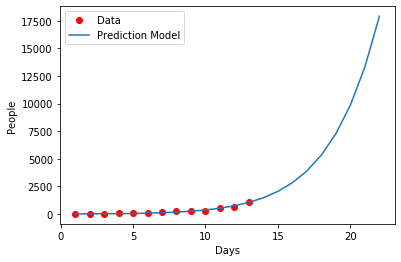

In [193]:
from scipy.optimize import curve_fit
#np.seterr("ignore")
#def aTrozos(x_data,a,n):

def expModel(x_data,a,b,c,d,e):
    #return (a**((x_data)*b+c) + d)
    return a/(b+np.exp(-(x_data)**d))

def fit(func,x_data,y_data):
    popt, pcov = curve_fit(expModel,x_data,y_data,maxfev = 10000, bounds=([0,0]+[-np.inf]*3, [np.inf]*5))
    print("Adjusted Parameters of a^(bx+c) + d: a={},b={}".format(*popt))
    return lambda x: expModel(x,*popt)

def fromFirstCase(country_df,param):
    df = country_df[country_df[param] > 10]
    if df.empty:
        return None
    else:
        return np.array(range(1,df.shape[0]+1)),np.array(df[param])

def prediction(country,param,days,fromNow=False):
    x_data,y_data = fromFirstCase(timeEvolution(country),param)
    adj = fit(expModel,x_data,y_data)
    if fromNow :
        x = range(len(x_data),len(x_data)+1+days)
    else:
        x = range(1,len(x_data)+days)
    
    y = adj(x)
    return x_data,y_data,pd.DataFrame([[day,people] for day,people in zip(x,y)])


def plotPrediction(x_data,y_data,df):
    x,y = df.loc[:,[0]],df.loc[:,[1]]
    plt.plot(x_data,y_data,'ro',label="Data")
    plt.plot(x,y,label="Prediction Model")
    plt.title = "{} {} prediction ({} days from ) "
    plt.xlabel("Days") 
    plt.ylabel("People")
    plt.legend()
x_data,y_data,df = prediction("Spain","Confirmed",10,fromNow=False)
df
plotPrediction(x_data,y_data,df)